In [1]:
# transformers: Provides tools for NLP, pandas: Handles data analysis and manipulation
!pip install transformers pandas

In [2]:
# # Importing required libraries
# import pandas as pd  # Pandas is used for handling and analyzing structured data in DataFrames
# from transformers import pipeline  # Transformers library provides pre-trained NLP models for various tasks
# from sklearn.feature_extraction.text import CountVectorizer  # Used for text vectorization and calculating uniqueness score

# # Load a Hugging Face pipeline for Named Entity Recognition (NER)
# "grouped_entities=True" ensures that sub-word tokens are grouped into full entities (e.g., "Joh" and "n" become "John")
# # The model "dbmdz/bert-large-cased-finetuned-conll03-english" is specifically fine-tuned for NER tasks
# ner_pipeline = pipeline("ner", grouped_entities=True, model="dbmdz/bert-large-cased-finetuned-conll03-english")

# # Load the dataset into a Pandas DataFrame
# # The CSV file path is provided as an input to read the dataset
# data = pd.read_csv('/content/updated_diagnosis_disease_full_cleaned (1).csv')

# # Specify all column names for pseudonymization
# # target_columns will contain a list of all column names from the DataFrame
# target_columns = data.columns.tolist()

# # Function to calculate a uniqueness score based on the number of unique words in the text
# def calculate_score(text):
#     """
#     Calculate the uniqueness score of the input text by counting the number of unique words.
#     """
#     vectorizer = CountVectorizer()  # Initialize the CountVectorizer to analyze word frequencies
#     matrix = vectorizer.fit_transform([text])  # Convert the text into a frequency matrix
#     return len(vectorizer.get_feature_names_out())  # Return the count of unique words (features)

# # Add a new column 'Original_Score' to store the uniqueness scores before pseudonymization
# data['Original_Score'] = data[target_columns].apply(
#     lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
# )  # Combine all non-null values in each row, calculate the score, and assign it to 'Original_Score'

# # Define a function to pseudonymize sensitive text using the Hugging Face NER pipeline
# def pseudonymize_with_transformers(text):
#     """
#     Replace sensitive entities in the text (e.g., Person, Organization, Location) with placeholders.
#     """
#     try:
#         entities = ner_pipeline(text)  # Extract entities from the input text using the NER pipeline
#         pseudonymized_text = text  # Initialize with the original text
#         for entity in entities:  # Iterate through each detected entity
#             if entity["entity_group"] in ["PER", "ORG", "LOC"]:  # Check if the entity is of a sensitive type
#                 # Replace the detected entity with a placeholder indicating its type
#                 pseudonymized_text = pseudonymized_text.replace(entity["word"], f"{entity['entity_group']}_REPLACEMENT")
#         return pseudonymized_text  # Return the pseudonymized text
#     except Exception as e:
#         # If any error occurs during pseudonymization, print the error and return the original text
#         print(f"Error during pseudonymization: {e}")
#         return text

# # Apply pseudonymization to all columns specified in target_columns
# for column in target_columns:
#     # Create new columns named 'Pseudonymized_<original_column>' for each column in target_columns
#     data[f'Pseudonymized_{column}'] = data[column].apply(
#         lambda x: pseudonymize_with_transformers(str(x)) if pd.notnull(x) else x  # Apply only if the value is not null
#     )

# # Add a new column 'Pseudonymized_Score' to store uniqueness scores after pseudonymization
# data['Pseudonymized_Score'] = data[[f'Pseudonymized_{col}' for col in target_columns]].apply(
#     lambda row: calculate_score(' '.join(row.dropna().astype(str))), axis=1
# )  # Combine all non-null pseudonymized values in each row, calculate the score, and assign it

# # Calculate the difference between original and pseudonymized uniqueness scores
# data['Score_Difference'] = data['Original_Score'] - data['Pseudonymized_Score']

# # Save the updated dataset with pseudonymized data to a new CSV file
# output_file = '/content/updated_result_with_transformers.csv'  # Specify the output file path
# data.to_csv(output_file, index=False)  # Save the DataFrame to the specified file without row indices

# # Select columns for comparison, including scores and pseudonymized data
# comparison_columns = ['Original_Score', 'Pseudonymized_Score', 'Score_Difference'] + [
#     col for col in data.columns if 'Pseudonymized' in col or col in target_columns
# ]

# # Extract the first 10 rows of the selected columns for display
# sample_data = data[comparison_columns].head(10)

# # Display a sample of the data for comparison
# print("Sample Data with Original and Pseudonymized Columns:")  # Print a header for clarity
# print(sample_data)  # Print the sample data to compare original and pseudonymized values
# print(f"\nPseudonymized data saved to '{output_file}'")  # Confirm the output file path where data is saved

In [4]:
# Importing required libraries
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load dataset and initialize NER pipeline
data = pd.read_csv('/content/updated_diagnosis_disease_full_cleaned (1).csv')
target_columns = data.columns.tolist()
ner_pipeline = pipeline("ner", grouped_entities=True, model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Initialize counters for visualization
entity_counts = {
    'before': {'PER': 0, 'ORG': 0, 'LOC': 0},
    'after': {'PER': 0, 'ORG': 0, 'LOC': 0}
}

# Modified pseudonymization function
def pseudonymize_with_transformers(text):
    """
    Returns pseudonymized text and list of replaced entities
    """
    try:
        entities = ner_pipeline(text)
        original_text = text
        pseudonymized_text = text
        replaced_entities = []

        # Process entities in reverse order
        for entity in reversed(sorted(entities, key=lambda x: x['start'])):
            if entity["entity_group"] in ["PER", "ORG", "LOC"]:
                start = entity["start"]
                end = entity["end"]
                original_entity = original_text[start:end]
                replacement = f"{entity['entity_group']}_REPLACEMENT"

                # Update text and counters
                pseudonymized_text = pseudonymized_text[:start] + replacement + pseudonymized_text[end:]
                replaced_entities.append({
                    'entity_type': entity['entity_group'],
                    'original_value': original_entity,
                    'replacement_value': replacement
                })

                # Update visualization counters
                entity_counts['before'][entity['entity_group']] += 1
                entity_counts['after'][entity['entity_group']] += 1

        return pseudonymized_text, replaced_entities

    except Exception as e:
        print(f"Error during pseudonymization: {e}")
        return text, []

# Process data and build outputs
comparison_records = []

for row_idx, row in data.iterrows():
    row_changes = []
    for col_name in target_columns:
        original_value = str(row[col_name]) if pd.notnull(row[col_name]) else ""
        pseudonymized_value, entities = pseudonymize_with_transformers(original_value)

        # Update DataFrame
        data.at[row_idx, f'Pseudonymized_{col_name}'] = pseudonymized_value

        # Record changes
        if entities:
            for entity in entities:
                row_changes.append({
                    'Row': row_idx + 1,
                    'Column': col_name,
                    'Entity Type': entity['entity_type'],
                    'Original': entity['original_value'],
                    'Replacement': entity['replacement_value'],
                    'Full Original': original_value,
                    'Full Pseudonymized': pseudonymized_value
                })

    if row_changes:
        comparison_records.extend(row_changes)

# ======================
# 1. Display Table
# ======================
if comparison_records:
    comparison_df = pd.DataFrame(comparison_records)[[
        'Row', 'Column', 'Entity Type', 'Original', 'Replacement',
        'Full Original', 'Full Pseudonymized'
    ]]

    print("\n=== Detailed Changes Table ===")
    print(comparison_df.to_string(index=False, max_colwidth=30))
else:
    print("No entities replaced.")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(



=== Detailed Changes Table ===
 Row  Column Entity Type        Original     Replacement                  Full Original             Full Pseudonymized
  46 Remarks         ORG              CD ORG_REPLACEMENT                        plan-CD           plan-ORG_REPLACEMENT
  47 Remarks         ORG              CD ORG_REPLACEMENT                        plan-CD           plan-ORG_REPLACEMENT
  50 Remarks         ORG              CD ORG_REPLACEMENT                       plan- CD          plan- ORG_REPLACEMENT
  87 Remarks         ORG              CD ORG_REPLACEMENT                        plan-CD           plan-ORG_REPLACEMENT
 223 Remarks         ORG             DJD ORG_REPLACEMENT                            DJD                ORG_REPLACEMENT
1085 Remarks         ORG              NR ORG_REPLACEMENT                             NR                ORG_REPLACEMENT
1090 Remarks         ORG              NR ORG_REPLACEMENT                             NR                ORG_REPLACEMENT
1095 Remarks    


=== Visualization ===


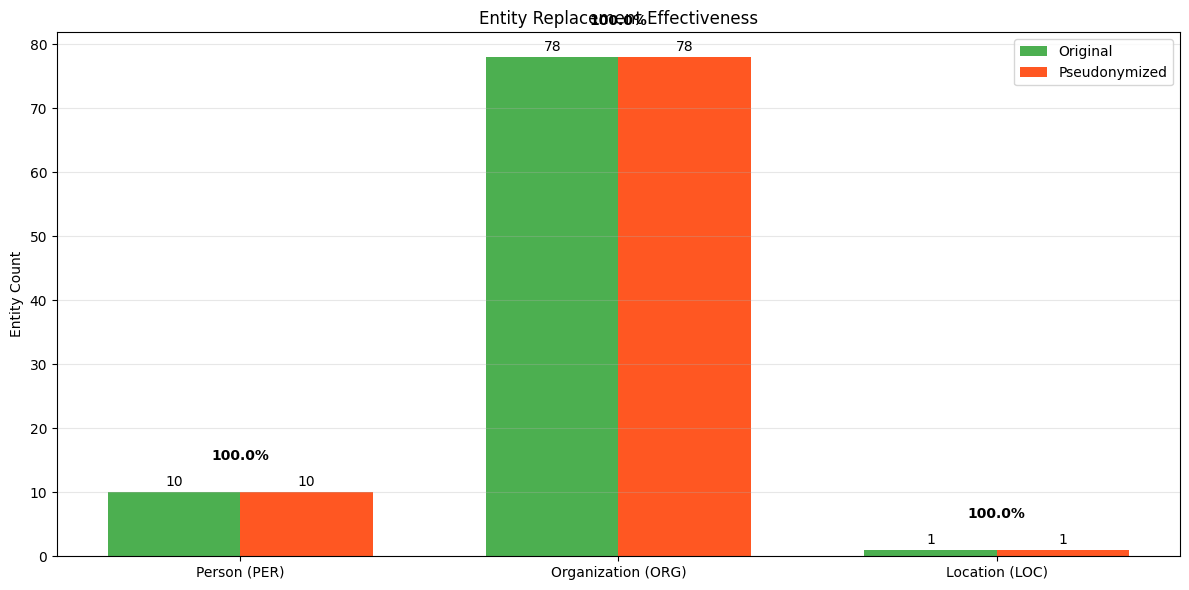

In [5]:

# ======================
# 2. Generate Plot
# ======================

labels = ['Person (PER)', 'Organization (ORG)', 'Location (LOC)']
before = [entity_counts['before'][k] for k in ['PER', 'ORG', 'LOC']]
after = [entity_counts['after'][k] for k in ['PER', 'ORG', 'LOC']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, before, width, label='Original', color='#4CAF50')
plt.bar(x + width/2, after, width, label='Pseudonymized', color='#FF5722')

plt.xticks(x, labels)
plt.ylabel('Entity Count')
plt.title('Entity Replacement Effectiveness')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add annotations
for i, (b, a) in enumerate(zip(before, after)):
    plt.text(i - width/2, b + 0.5, f'{b}', ha='center', va='bottom')
    plt.text(i + width/2, a + 0.5, f'{a}', ha='center', va='bottom')
    percentage = (a/b)*100 if b > 0 else 0
    plt.text(i, max(b,a) + 5, f'{percentage:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
print("\n=== Visualization ===")
plt.show()


In [6]:
# ======================
# 3. Save Results
# ======================

output_path = '/content/updated_result_with_BERT.csv'
data.to_csv(output_path, index=False)
print(f"\nSaved pseudonymized data to: {output_path}")


Saved pseudonymized data to: /content/updated_result_with_BERT.csv


In [7]:
# ======================
# Calculate Percentages
# ======================

def calculate_percentages(before, after):
    percentages = {}
    for ent_type in ['PER', 'ORG', 'LOC']:
        try:
            percentages[ent_type] = (after[ent_type] / before[ent_type]) * 100
        except ZeroDivisionError:
            percentages[ent_type] = 0.0
    return percentages

# Get percentages
replacement_percentages = calculate_percentages(
    entity_counts['before'],
    entity_counts['after']
)

# Create and display percentage table
percentage_df = pd.DataFrame({
    'Entity Type': ['Person (PER)', 'Organization (ORG)', 'Location (LOC)'],
    'Total Entities': [entity_counts['before']['PER'],
                      entity_counts['before']['ORG'],
                      entity_counts['before']['LOC']],
    'Replaced Entities': [entity_counts['after']['PER'],
                         entity_counts['after']['ORG'],
                         entity_counts['after']['LOC']],
    'Replacement Rate (%)': [replacement_percentages['PER'],
                            replacement_percentages['ORG'],
                            replacement_percentages['LOC']]
})

print("\n=== Replacement Effectiveness Summary ===")
print(percentage_df.to_string(index=False, float_format="%.1f"))


=== Replacement Effectiveness Summary ===
       Entity Type  Total Entities  Replaced Entities  Replacement Rate (%)
      Person (PER)              10                 10                 100.0
Organization (ORG)              78                 78                 100.0
    Location (LOC)               1                  1                 100.0
